# ResNet残差网络
在 ResNet 提出之前，普遍认为：

网络的深度（层数）越深，模型的表达能力越强，性能越好。
但实际上，随着网络深度的增加，模型的性能会饱和甚至下降。这种现象被称为 网络退化问题（Degradation Problem）。    

ResNet 通过引入 残差学习，成功训练了超过 100 层的深层网络，并显著提升了模型的性能。

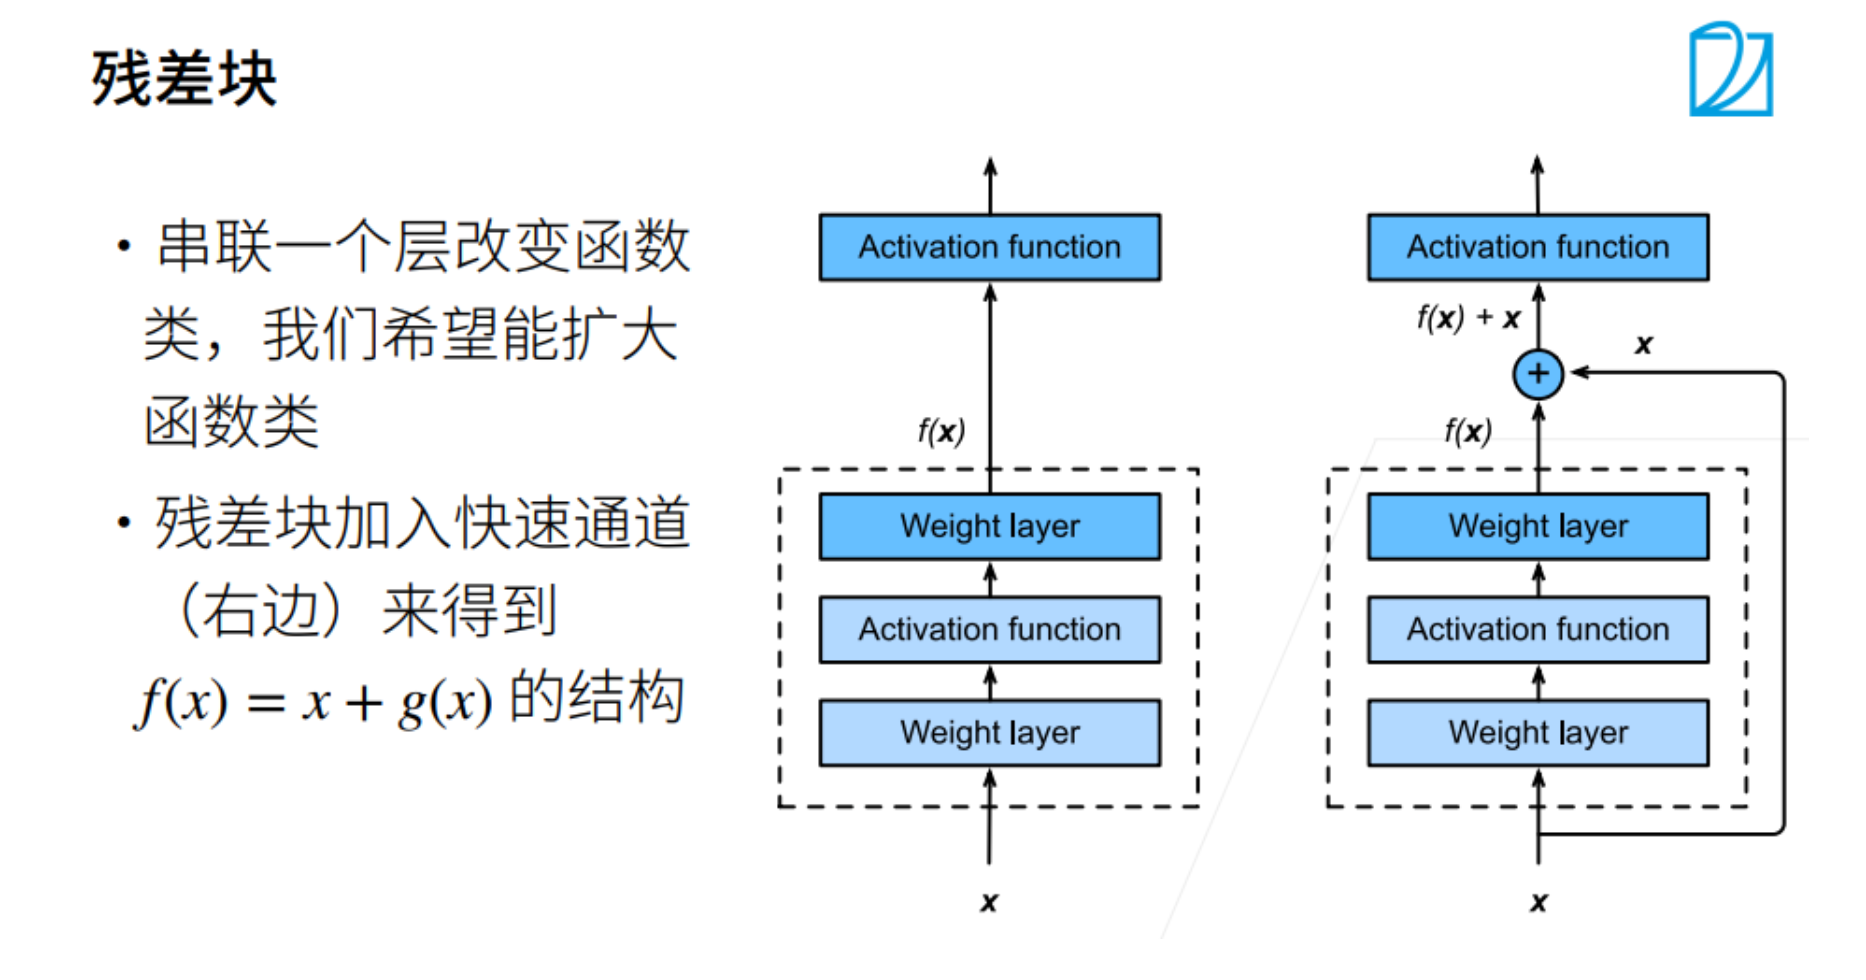

细节：
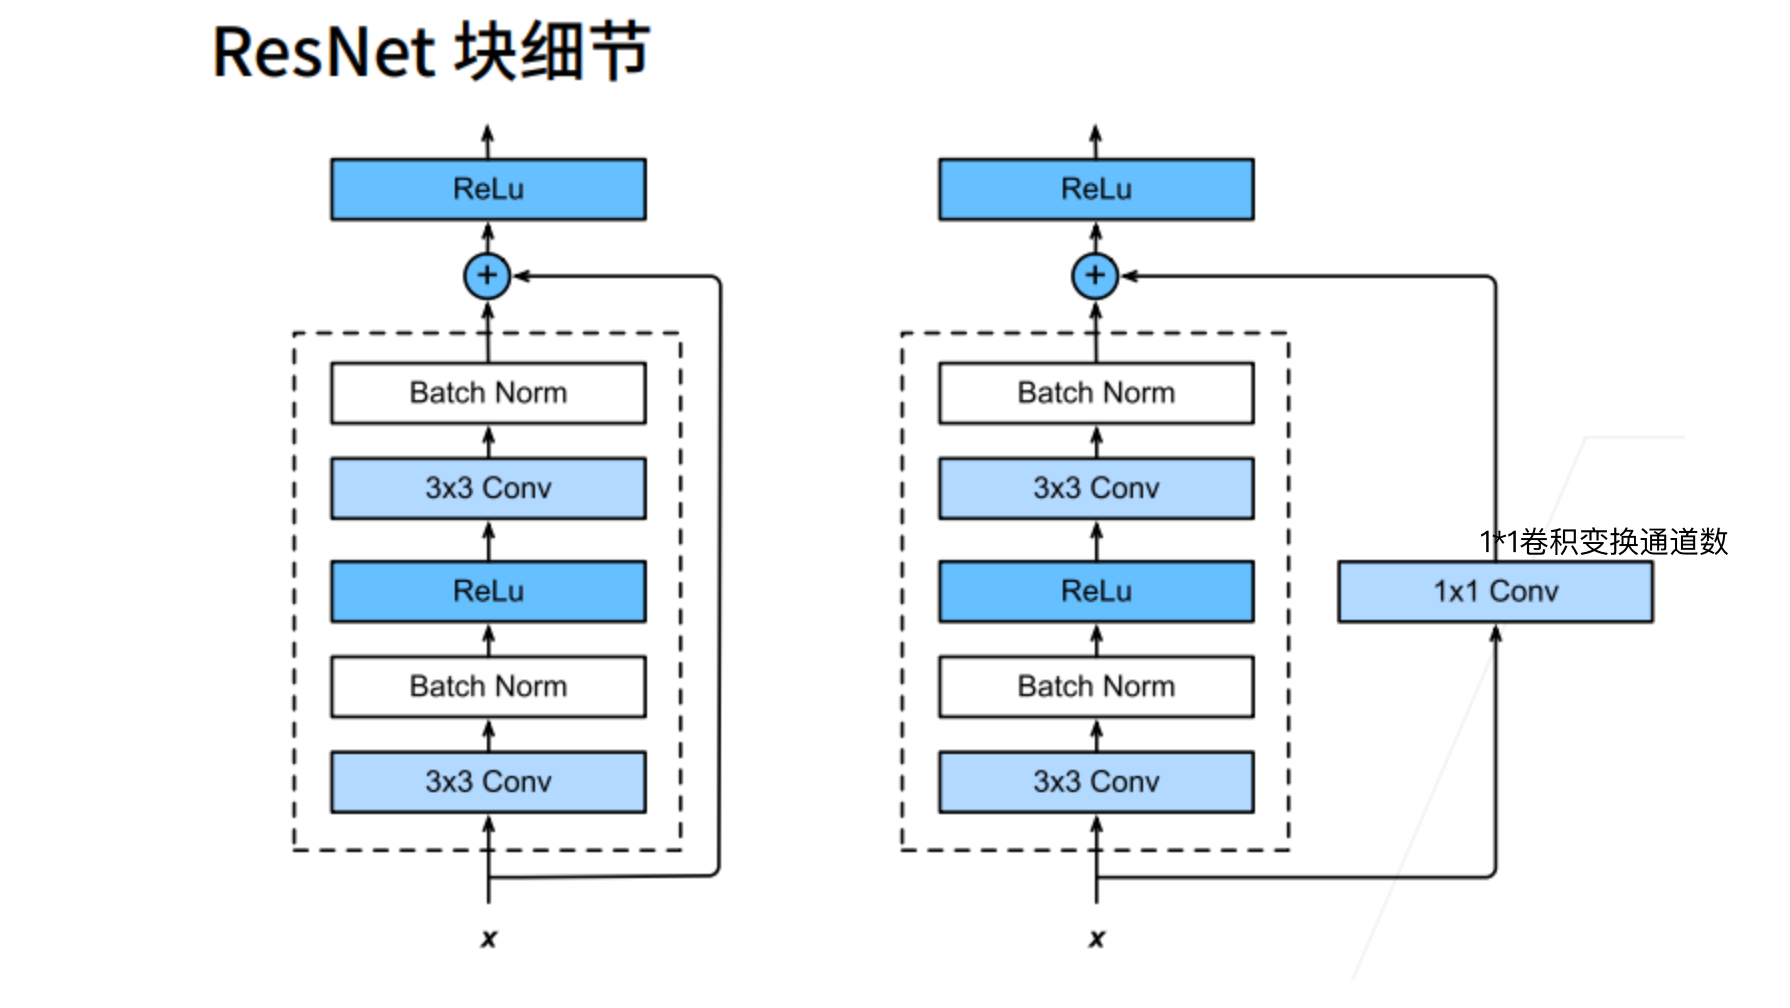

一般有两种ResNet块：
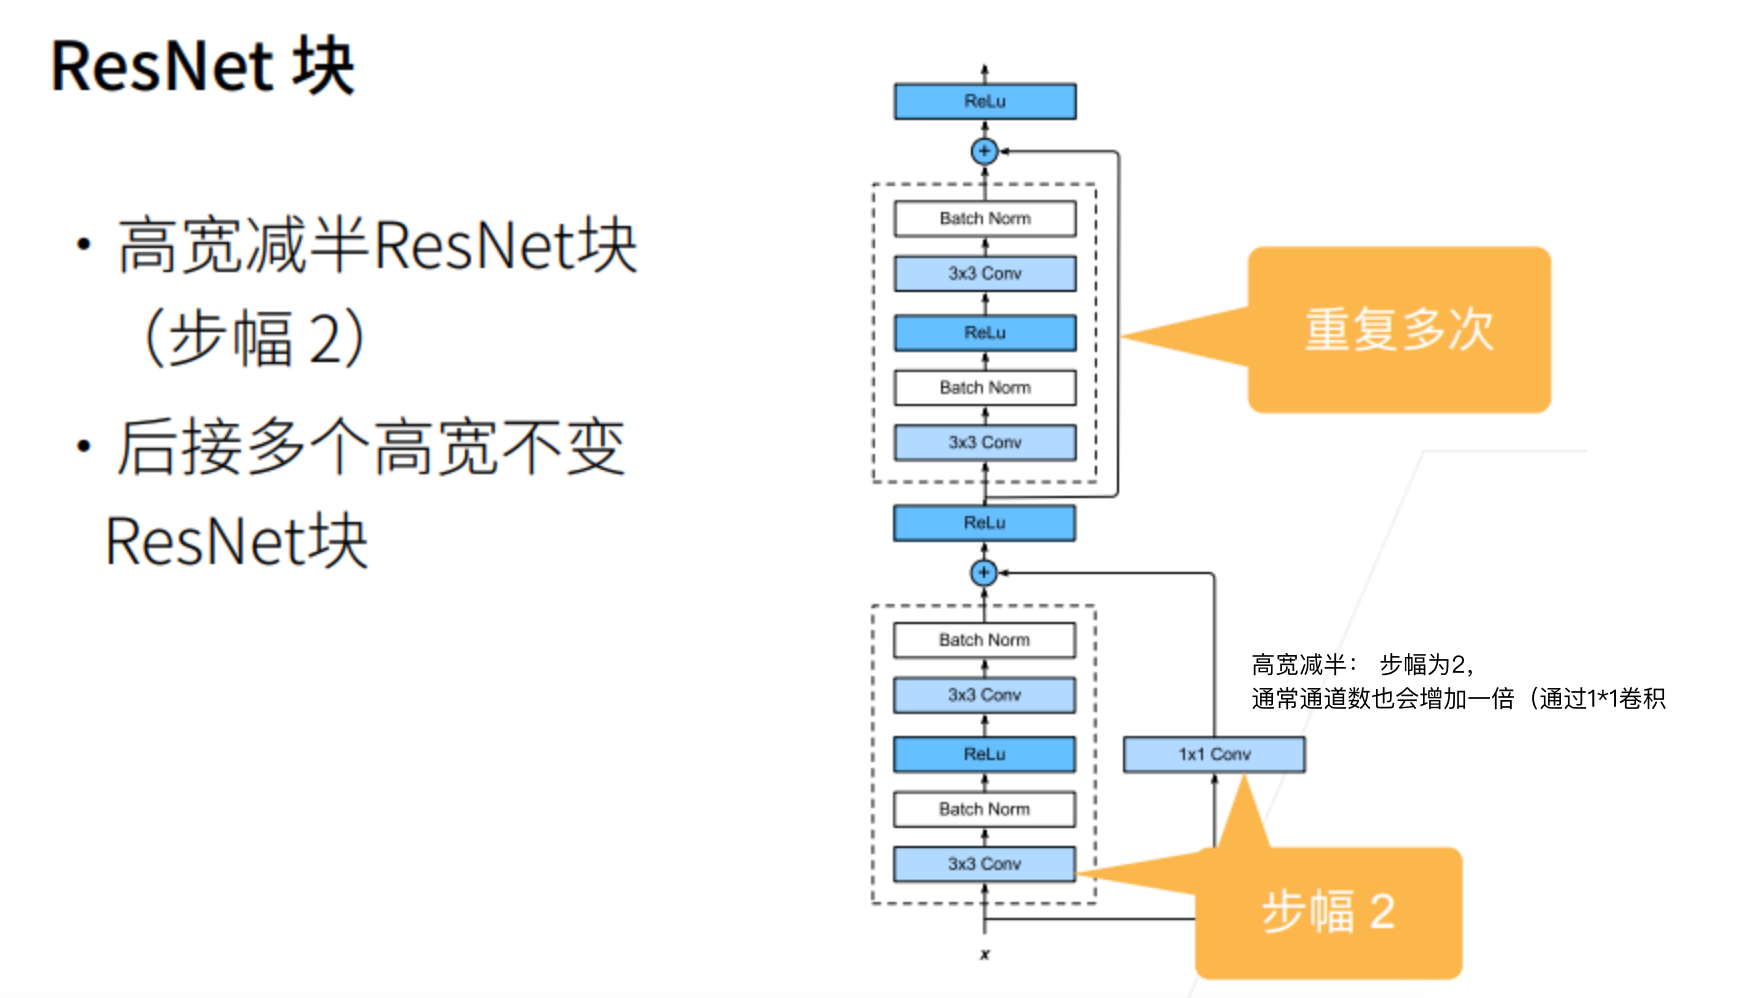

ResNet架构：类似VGG和GoogleNet的总体架构。但替换成了ResNet块
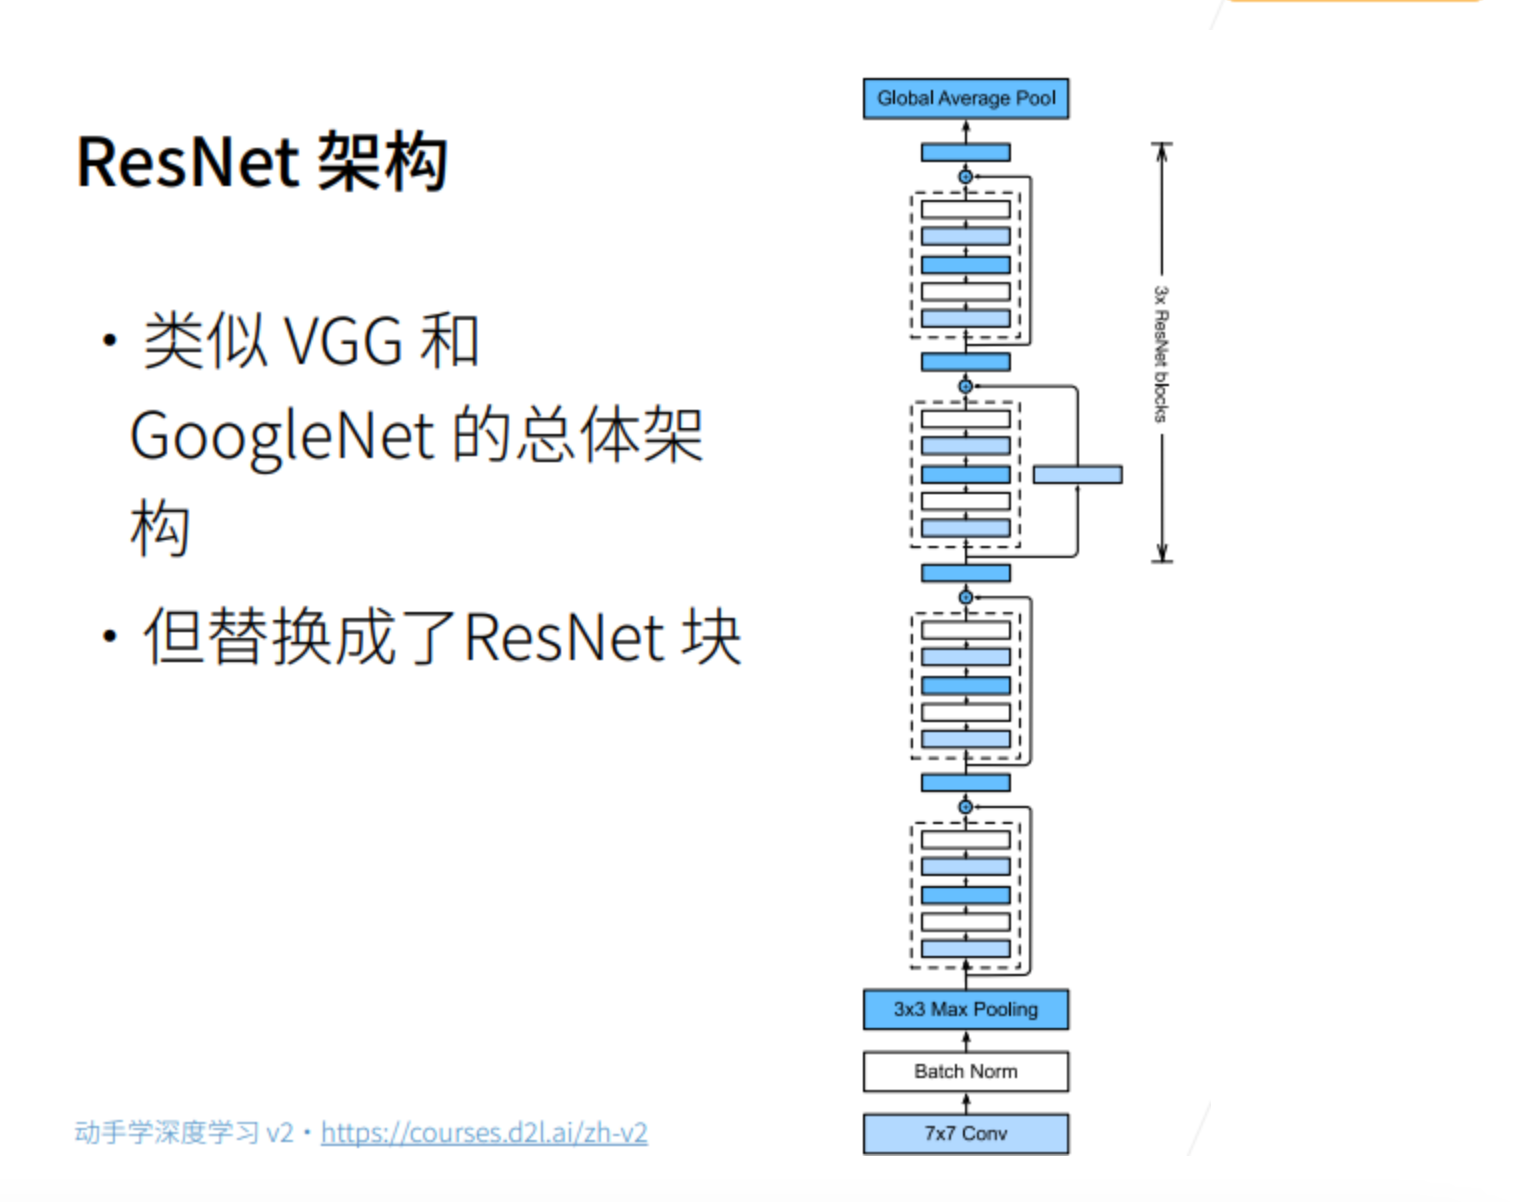

代码：

In [5]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class Residual(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [27]:
blk = Residual(3,6, use_1x1conv=True, strides=2)
X = torch.rand(4,3,8,8)
Y = blk(X)  # 调用了 Residual 类实例 blk 的 forward 方法
Y.shape
blk(X).shape

torch.Size([4, 6, 4, 4])

补充：nn.Sequential 具有嵌套组合的能力，它可以包含其他 nn.Sequential 对象。这使得我们能够灵活地构建复杂的神经网络结构，将多个子模块按层次和顺序组合在一起。因此，b1、b2、b3、b4、b5 这些 nn.Sequential 对象可以被进一步组合到一个更大的 nn.Sequential 容器中。

In [32]:
import torch
import torch.nn as nn

# 假设 Residual 类已经定义
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = nn.functional.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return nn.functional.relu(Y)

def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

b1 = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True)) #* 作为解包操作符使用
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Flatten(),
                    nn.Linear(512, 10))

# 模拟输入数据
input_data = torch.randn(1, 3, 224, 224)
output = net(input_data)
print(output)

tensor([[ 0.2326,  0.5130, -0.2733,  0.0491, -0.5737, -0.7134,  0.0901,  0.1090,
         -0.1447,  0.1441]], grad_fn=<AddmmBackward0>)
